In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Importieren der CSV

In [300]:
track_data = pd.read_csv('Rohdaten_Stündlich_QB_2024_06_06.csv', sep = ';')

In [301]:
track_data.head()

,CustomIntervall,Unnamed: 1,linecount Zugang Europaviertel,linecount Bahnsteig01,linecount Bahnsteig02,linecount Bahnsteig03,linecount Bahnsteig04,linecount Bahnsteig05,linecount Bahnsteig06,linecount Bahnsteig07,...,STG_QB04_Steg01,STG_Bonatz10_Steg01,STG_QB12_Steg02,STG_Bonatz13_Steg02,STG_Bonatz04,linecount Zugang Infoturm Stuttgart,linecount Zugang Schlossgarten,(AB) linecount Zugang Schlossgarten+ITS,Bahnsteige Gesamt angepasst,Steg 02 Gesamt
0,01.01.2023 00:00,NaN,362,155,68,39,253,193,0,303,...,0,0,0,0,942,0,49,0,1.344,942.0
1,01.01.2023 01:00,NaN,482,251,94,108,550,138,0,406,...,0,0,0,0,874,6,71,0,1.979,874.0
2,01.01.2023 02:00,NaN,402,136,103,75,257,164,0,490,...,0,0,0,0,628,4,42,0,1.509,628.0
3,01.01.2023 03:00,NaN,363,144,109,89,356,97,0,222,...,0,0,0,0,611,2,45,0,1.304,611.0
4,01.01.2023 04:00,NaN,430,193,81,56,273,263,0,271,...,0,0,0,0,689,2,31,0,1.426,689.0


### Filtern von nicht notwendigen Zeilen
Es ist für die Analyse nur der Zeitpunkt, sowie der Bahnsteig relevant. 

In [302]:
# Spaltennamen anzeigen
print(track_data.columns)

Index(['CustomIntervall', 'Unnamed: 1', ' linecount Zugang Europaviertel',
       ' linecount Bahnsteig01', ' linecount Bahnsteig02',
       ' linecount Bahnsteig03', ' linecount Bahnsteig04',
       ' linecount Bahnsteig05', ' linecount Bahnsteig06',
       ' linecount Bahnsteig07', ' linecount Bahnsteig08', ' Querbahnsteig',
       ' STG_QB04_Steg01', ' STG_Bonatz10_Steg01', ' STG_QB12_Steg02',
       ' STG_Bonatz13_Steg02', ' STG_Bonatz04',
       ' linecount Zugang Infoturm Stuttgart',
       ' linecount Zugang Schlossgarten',
       ' (AB) linecount Zugang Schlossgarten+ITS',
       'Bahnsteige Gesamt angepasst', 'Steg 02 Gesamt'],
      dtype='object')


In [303]:
# Auswahl der gewünschten Spalten anhand der tatsächlich vorhandenen Spaltennamen
selected_columns = ['CustomIntervall', ' linecount Bahnsteig01', ' linecount Bahnsteig02', ' linecount Bahnsteig03', ' linecount Bahnsteig04', ' linecount Bahnsteig05', ' linecount Bahnsteig07', ' linecount Bahnsteig08']
filtered_data = track_data[selected_columns].copy()  # Explizit eine Kopie erstellen

# Sicherstellen, dass das Datum korrekt als Datetime-Typ eingelesen wird
filtered_data['CustomIntervall'] = pd.to_datetime(filtered_data['CustomIntervall'], format='%d.%m.%Y %H:%M')
filtered_data.set_index('CustomIntervall', inplace=True)

# Das gefilterte DataFrame anzeigen
filtered_data.head()

,linecount Bahnsteig01,linecount Bahnsteig02,linecount Bahnsteig03,linecount Bahnsteig04,linecount Bahnsteig05,linecount Bahnsteig07,linecount Bahnsteig08
CustomIntervall,,,,,,,
2023-01-01 00:00:00,155,68,39,253,193,303,333
2023-01-01 01:00:00,251,94,108,550,138,406,432
2023-01-01 02:00:00,136,103,75,257,164,490,284
2023-01-01 03:00:00,144,109,89,356,97,222,287
2023-01-01 04:00:00,193,81,56,273,263,271,289


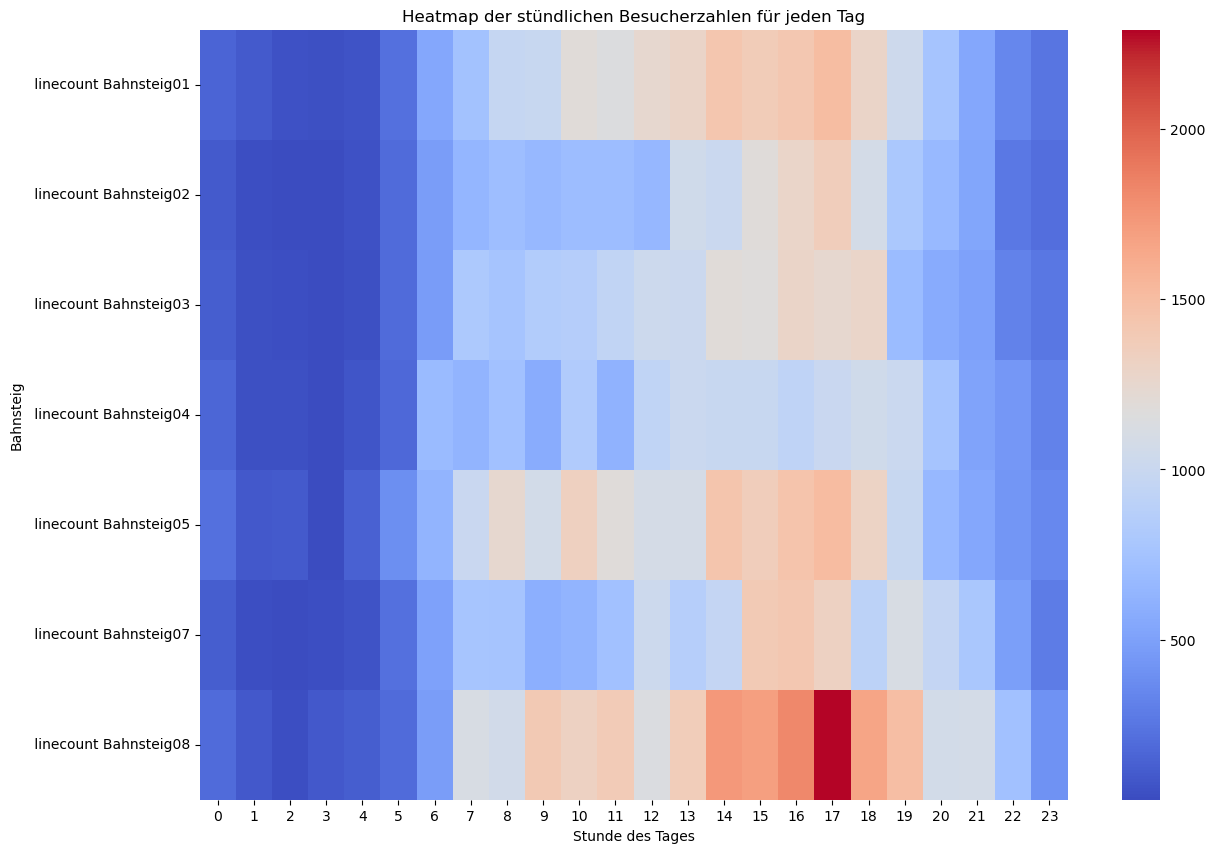

In [304]:
# Resampling der Daten, um stündliche Mittelwerte zu berechnen
hourly_data = filtered_data.resample('H').mean()

# Umstrukturieren der Daten für die Heatmap (Bahnsteige als Zeilen, Stunden als Spalten)
hourly_data_pivot = hourly_data.pivot_table(values=[' linecount Bahnsteig01', ' linecount Bahnsteig02', ' linecount Bahnsteig03', ' linecount Bahnsteig04', ' linecount Bahnsteig05', ' linecount Bahnsteig07', ' linecount Bahnsteig08'], index=hourly_data.index.hour)

# Erstellen der Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(hourly_data_pivot.T, cmap="coolwarm", annot=False)
plt.title('Heatmap der stündlichen Besucherzahlen für jeden Tag')
plt.xlabel('Stunde des Tages')
plt.ylabel('Bahnsteig')
plt.show()

### Die Funktion ermöglicht es, Besucherzahl anhand von einem Datensatz hervorzusagen
Es wird dafür nur ein Datum im Format "yyyy-mm-dd" benötigt.

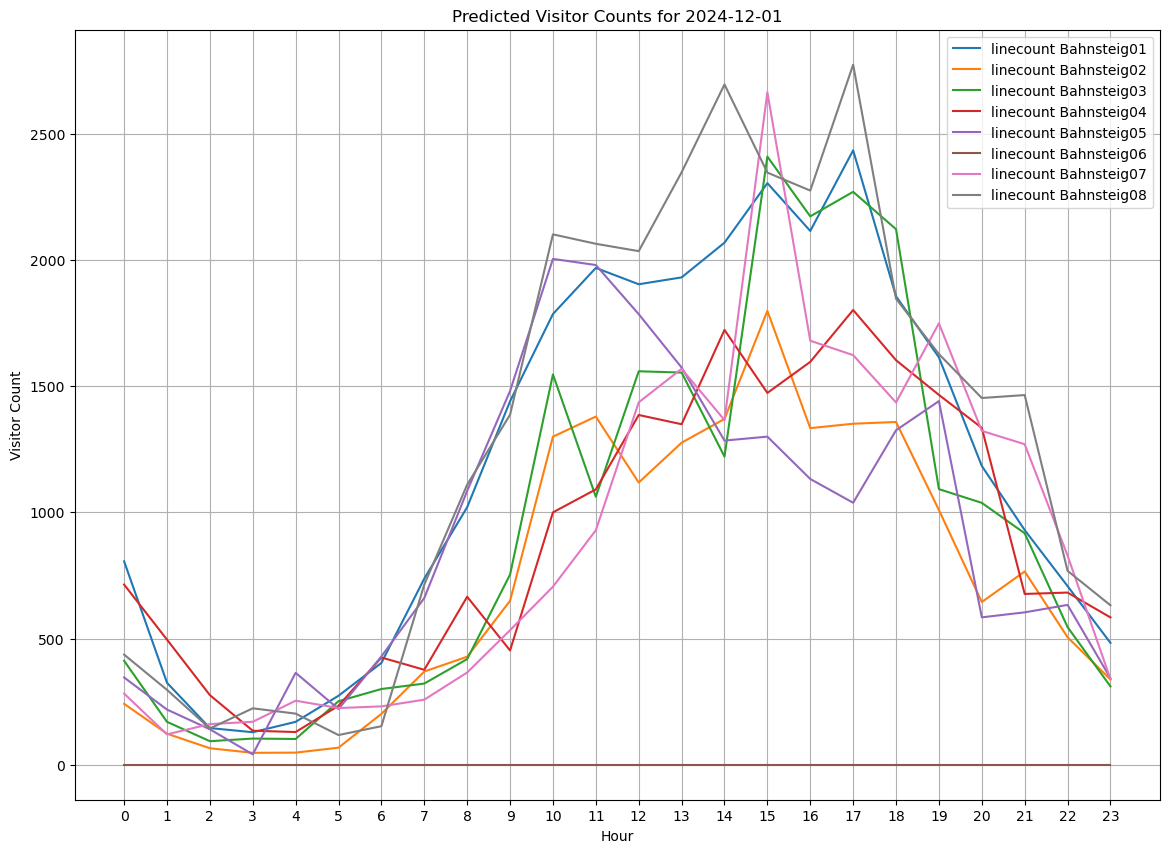

In [305]:
# Schulferien und Feiertage definieren
school_holidays = [
    ('2024-05-21', '2024-05-31'),
    ('2024-07-25', '2024-09-07'),
    ('2024-10-28', '2024-10-30'),
    ('2024-12-23', '2025-01-04')
]

public_holidays = [
    '2024-05-09', '2024-05-20', '2024-05-30', '2024-10-03',
    '2024-11-01', '2024-12-25', '2024-12-26'
]

# Konvertiere Feiertage zu Datetime
public_holidays = pd.to_datetime(public_holidays)

def is_holiday(date):
    return date in public_holidays

def is_school_holiday(date):
    for start, end in school_holidays:
        if start <= date.strftime('%Y-%m-%d') <= end:
            return True
    return False

def predict_visitors(date_str):
    # Importieren der CSV-Datei
    track_data = pd.read_csv('Rohdaten_Stündlich_QB_2024_06_06.csv', sep=';')

    # Auswahl der gewünschten Spalten anhand der tatsächlich vorhandenen Spaltennamen
    selected_columns = ['CustomIntervall', ' linecount Bahnsteig01', ' linecount Bahnsteig02', ' linecount Bahnsteig03', ' linecount Bahnsteig04', ' linecount Bahnsteig05', ' linecount Bahnsteig06', ' linecount Bahnsteig07', ' linecount Bahnsteig08']
    filtered_data = track_data[selected_columns].copy()  # Explizit eine Kopie erstellen

    # Sicherstellen, dass das Datum korrekt als Datetime-Typ eingelesen wird
    filtered_data.columns = filtered_data.columns.str.strip()  # Entfernen von Leerzeichen aus Spaltennamen
    filtered_data['CustomIntervall'] = pd.to_datetime(filtered_data['CustomIntervall'], format='%d.%m.%Y %H:%M')

    # Extrahieren von Merkmalen aus dem Datum
    filtered_data['hour'] = filtered_data['CustomIntervall'].dt.hour
    filtered_data['day'] = filtered_data['CustomIntervall'].dt.day
    filtered_data['month'] = filtered_data['CustomIntervall'].dt.month
    filtered_data['weekday'] = filtered_data['CustomIntervall'].dt.weekday
    filtered_data['is_holiday'] = filtered_data['CustomIntervall'].dt.date.apply(lambda x: is_holiday(pd.to_datetime(x)))
    filtered_data['is_school_holiday'] = filtered_data['CustomIntervall'].dt.date.apply(lambda x: is_school_holiday(pd.to_datetime(x)))

    # Zielvariable (zum Beispiel Besucherzahlen auf Bahnsteig 1-8)
    targets = ['linecount Bahnsteig01', 'linecount Bahnsteig02', 'linecount Bahnsteig03', 'linecount Bahnsteig04', 'linecount Bahnsteig05', 'linecount Bahnsteig06', 'linecount Bahnsteig07', 'linecount Bahnsteig08']

    # Features definieren
    X = filtered_data[['hour', 'day', 'month', 'weekday', 'is_holiday', 'is_school_holiday']]
    
    # Random Forest Regressor Modell trainieren für jeden Bahnsteig
    models = {}
    for target in targets:
        y = filtered_data[target]
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        models[target] = rf

    # Daten für den angegebenen Tag erstellen
    pred_date = pd.to_datetime(date_str)
    pred_data = pd.DataFrame({
        'hour': range(24),
        'day': [pred_date.day] * 24,
        'month': [pred_date.month] * 24,
        'weekday': [pred_date.weekday()] * 24,
        'is_holiday': [is_holiday(pred_date)] * 24,
        'is_school_holiday': [is_school_holiday(pred_date)] * 24
    })

    # Vorhersagen machen
    predictions = {}
    for target in targets:
        model = models[target]
        predictions[target] = model.predict(pred_data)

    # Vorhersagen visualisieren
    plt.figure(figsize=(14, 10))
    for target in targets:
        plt.plot(range(24), predictions[target], label=target)
    plt.xticks(range(24))  # Setzt x-Achsenbeschriftungen auf jede Stunde
    plt.legend()
    plt.title(f'Predicted Visitor Counts for {date_str}')
    plt.xlabel('Hour')
    plt.ylabel('Visitor Count')
    plt.grid(True)  # Fügt ein Raster hinzu, um die Ablesbarkeit zu verbessern
    plt.show()

# Beispielaufruf der Funktion
predict_visitors('2024-12-01')